# Geographical mapping with `elevatr` and `tif`

An attempt to get geo working for our data.

The successful approach uses `elevatr` to download elevation data, converts the raster to a tif, and then shows this with cities as points.

We can adapt any data source to this approach, in particular we can show our language data on these maps.

# Additional reference

## Open Street maps:

[Old walkthrough](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)

[Documentation](https://osmnx.readthedocs.io)

[plotting examples from the oosmnx](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb):

## Geopandas

We do use geopandas for plotting points, but not for the raster.

## pygadm

We get our data using [pygadm](https://pypi.org/project/pygadm/).


In [1]:
import elevatr as elv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rioxarray as rxr
import numpy as np
import matplotlib.colors as mcolors

In [2]:
import pandas as pd

cities = pd.DataFrame({
    "City": [
        "Jakarta", "Surabaya", "Bandung", "Medan", "Makassar",       # Indonesia
        "Manila", "Quezon City", "Davao City", "Cebu City", "Zamboanga City"  # Philippines
    ],
    "Latitude": [
        -6.2088, -7.2504, -6.9175, 3.5952, -5.1477,   # Indonesia
        14.5995, 14.6760, 7.1907, 10.3157, 6.9214     # Philippines
    ],
    "Longitude": [
        106.8456, 112.7688, 107.6191, 98.6722, 119.4327,  # Indonesia
        120.9842, 121.0437, 125.4553, 123.8854, 122.0790  # Philippines
    ],
    "Country": [
        "Indonesia", "Indonesia", "Indonesia", "Indonesia", "Indonesia",
        "Philippines", "Philippines", "Philippines", "Philippines", "Philippines"
    ]
})

In [4]:
# Define the bounding box of the area of interest (min_lon, min_lat, max_lon, max_lat)
bbx=(95,-10.4,152,18.7)

# Set the level of precision (between 0 and 14)
zoom = 6

# Access the elevation data
# You can choose the crs of the output raster
raster = elv.get_elev_raster(locations=bbx, zoom=zoom, crs="EPSG:3857")

Mosaicing tiles.


In [6]:
raster.to_tif("ISEA_elevation.tif")

In [5]:
# Convert to GeoDataFrame
cities["geometry"] = cities.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
cities_gdf = gpd.GeoDataFrame(cities, geometry="geometry", crs="EPSG:4326")

In [9]:
# Load the saved raster with rioxarray
rds = rxr.open_rasterio("ISEA_elevation.tif", masked=True).squeeze()

In [10]:
# Reproject to raster CRS
cities_gdf = cities_gdf.to_crs(rds.rio.crs)

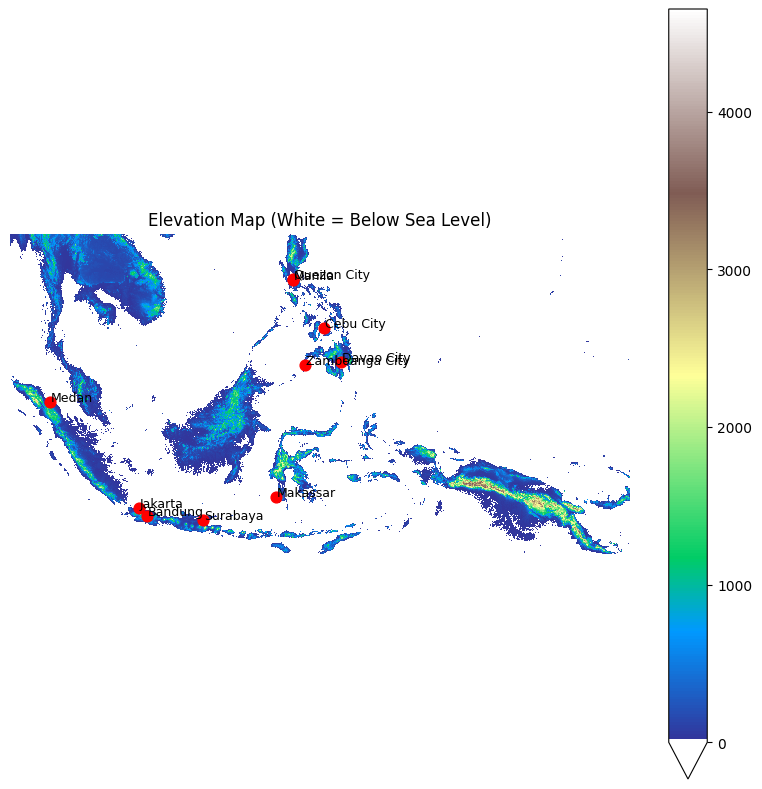

In [11]:

# Mask values below sea level
below_sea_mask = rds < 0

# Create a custom colormap: white for sea, terrain for land
terrain_cmap = plt.cm.terrain
new_colors = terrain_cmap(np.linspace(0, 1, 256))
new_colors[0] = [1, 1, 1, 1]  # Make lowest value (usually deep sea) white
custom_cmap = mcolors.ListedColormap(new_colors)

# Normalize so that 0 becomes the lowest visible color
vmin = 0
vmax = float(rds.max())

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
rds.plot(
    ax=ax,
    cmap=custom_cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=True
)

# Overlay cities
cities_gdf.plot(ax=ax, color='red', markersize=60)

# Add city labels
for x, y, label in zip(cities_gdf.geometry.x, cities_gdf.geometry.y, cities_gdf["City"]):
    ax.text(x + 10000, y + 10000, label, fontsize=9, color='black')

plt.title("Elevation Map (White = Below Sea Level)")
plt.axis('off')
plt.show()